<a href="https://colab.research.google.com/github/AnnaMakarova28/center-out/blob/main/Toroidal_topology_ECoG_data_center_out.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install cython

In [ ]:
pip install ripser

In [ ]:
pip install umap-learn

In [ ]:
from ripser import ripser
from persim import plot_diagrams
import pywt
import umap

In [ ]:
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io
import scipy

from sklearn.decomposition import PCA

In [ ]:
# Upload file from Google Drive (Center_out_project / Patient)
data_A = scipy.io.loadmat('/content/drive/MyDrive/Center_out_project/A/co_van_A_mov___ecog_trials_parsorted_valid.mat')

# Get an array of the data
# Result: data.shape = (1, 8) directions
data_A = data_A.get('co_van_A_mov___ecog_trials_parsorted_valid')

In [ ]:
# Get data.shape = (8,) directions
data_A = np.squeeze(data_A)

In [ ]:
# Concatenate trials (8 directions x 10 trials => 80 trials)
data_concatenated = data_A[1]
for direction in range(data_A.size - 1):
  data_concatenated = np.concatenate((data_concatenated, data_A[direction + 1]), axis=0)

In [ ]:
data_concatenated = data_concatenated.reshape(29,64,7168)

In [ ]:
# Get 1st trial data (7168,64)
data_first_trial = data_concatenated[0]

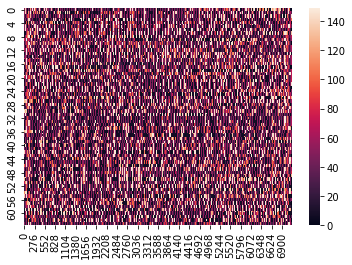

In [ ]:
# Get matrix (ch, times) with max frequency in every time point
max_freq = []
for ch in range(data_first_trial.shape[0]):
  coef, freqs = pywt.cwt(data_first_trial[ch],np.arange(1,151),'morl')
  coef_max = coef.argmax(axis=0)
  max_freq.append(coef_max)

max_freq = np.array(max_freq)
sns.heatmap(max_freq)

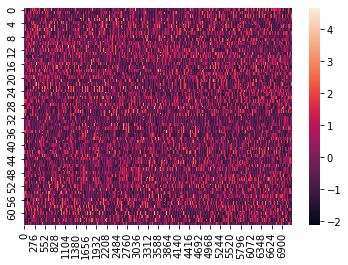

In [ ]:
# z-score normalization
max_freq_zscored = scipy.stats.zscore(max_freq)
sns.heatmap(max_freq_zscored)

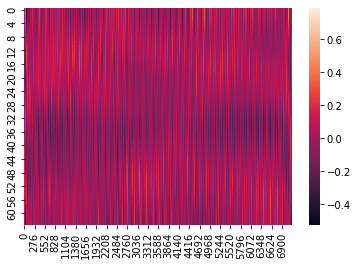

In [ ]:
# Gaussian smoothing
max_freq_gaus = scipy.ndimage.gaussian_filter(max_freq_zscored, sigma=5)
sns.heatmap(max_freq_gaus)

In [ ]:
# PCA
pca = PCA(n_components=5)
data_PCA = pca.fit(max_freq_gaus.T)
PCA_result = data_PCA.transform(max_freq_gaus.T)

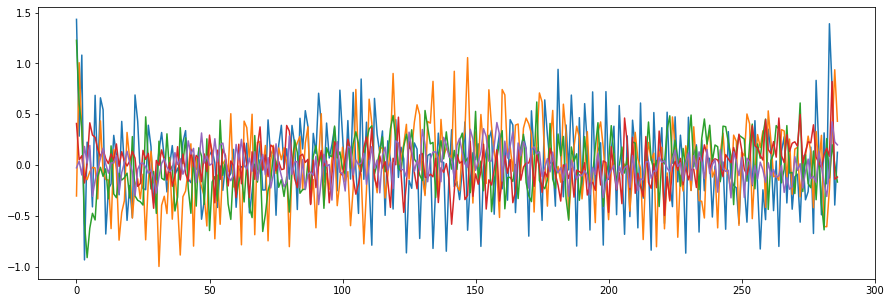

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(PCA_result[0:7168:25])

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


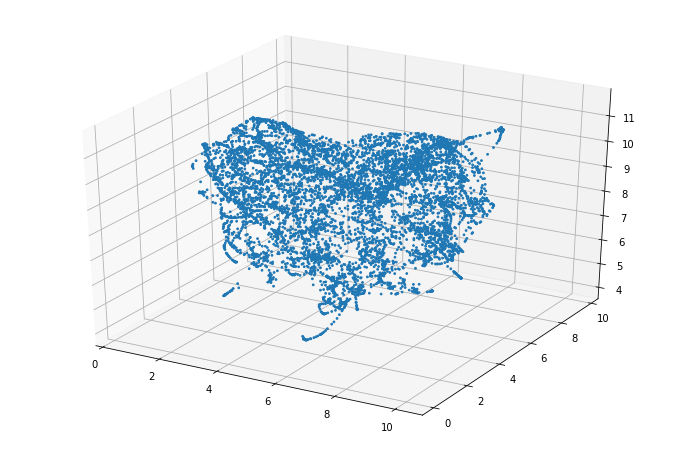

In [ ]:
# Reduce dimentionality to 3D with UMAP => (times,3)
reducer = umap.UMAP(n_components=3)
embedding = reducer.fit_transform(PCA_result)
plt.rcParams["figure.figsize"] = [12, 8]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = embedding.T[0]
y = embedding.T[1]
z = embedding.T[2]
ax.scatter(x, y, z, alpha=1, s=3)
plt.show()

In [ ]:
diagrams = ripser(embedding)['dgms']

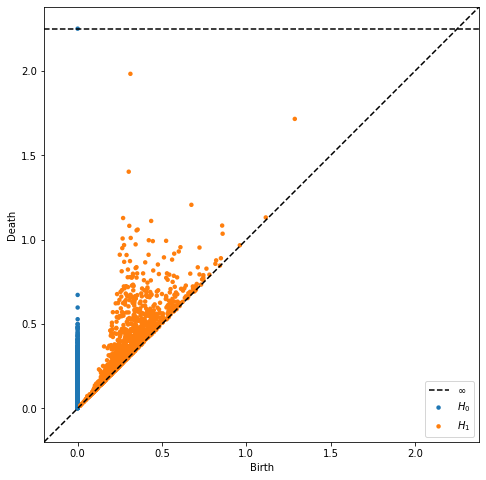

In [ ]:
# diagrams = ripser(embedding, maxdim=2)['dgms']
plot_diagrams(diagrams, show=True)